In [2]:
%matplotlib inline

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sbn

# the formula API allow us to write R-like formulas for regression models
import statsmodels as sm
import statsmodels.stats.anova as anova
import statsmodels.formula.api as smf  

In [3]:
np.random.seed(20160425)
sbn.set_style("white")

## Regression as sum-of-squares decomposition

#### Example data sets

We setup two synthetic data sets -- one where $Y$ is independent of $X$, and a second where $Y$ is depedendent on $X$.

In [4]:
n = 25
x = np.linspace(-5, 5, n) + stats.norm.rvs(loc=0, scale=1, size=n)

a, b = 1, 0.75

# I've chosen values to make yind and ydep have about the same variance
yind = a + stats.norm.rvs(loc=0, scale=np.sqrt(8), size=n) 
ydep = a + b*x + stats.norm.rvs(loc=0, scale=1, size=n)

# create two different data frames for ease of use with statsmodels
data_ind = pd.DataFrame(dict(x = x, y = yind))
data_dep = pd.DataFrame(dict(x = x, y = ydep))

And we plot the data sets

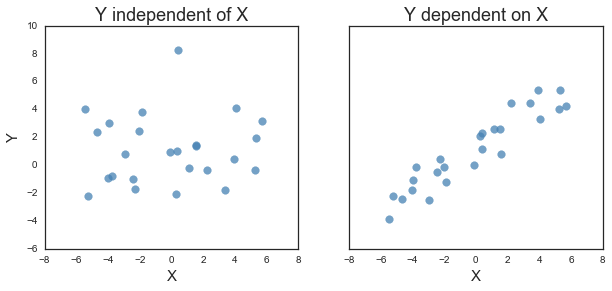

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
ax1.scatter(x, yind, s=60, alpha=0.75, color='steelblue')
ax2.scatter(x, ydep, s=60, alpha=0.75, color='steelblue')

ax1.set_xlabel("X",fontsize=15)
ax1.set_ylabel("Y",fontsize=15)
ax1.set_title("Y independent of X", fontsize=18)

ax2.set_xlabel("X",fontsize=15)
ax2.set_title("Y dependent on X", fontsize=18)

pass

### Fit the regressions with statsmodels

In [6]:
fit_ind = smf.ols('y ~ x', data_ind).fit()
fit_dep = smf.ols('y ~ x', data_dep).fit()

### Plot the regressions using info return by statsmodels

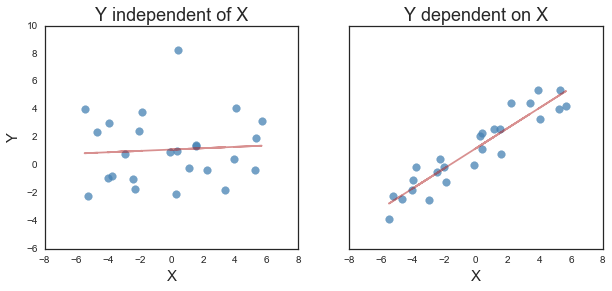

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)

ax1.scatter(x, yind, s=60, alpha=0.75, color='steelblue')
ax1.plot(x, fit_ind.predict(), color='firebrick', alpha=0.5)

ax2.scatter(x, ydep, s=60, alpha=0.75, color='steelblue')
ax2.plot(x, fit_dep.predict(), color='firebrick', alpha=0.5)

ax1.set_xlabel("X",fontsize=15)
ax1.set_ylabel("Y",fontsize=15)
ax1.set_title("Y independent of X", fontsize=18)

ax2.set_xlabel("X",fontsize=15)
ax2.set_title("Y dependent on X", fontsize=18)

pass

### Functions to decompose sums of squares

In [8]:
def sum_squares(x):
    x = np.asarray(x)
    return np.sum((x - np.mean(x))**2)


def bivariate_regression_table(fit):
    """ A function to create an ANOVA-like table for a bivariate regression"""
    df_model = fit.df_model
    df_resid = fit.df_resid
    df_total = df_model + df_resid

    SStotal = sum_squares(fit.model.endog)
    SSmodel = sum_squares(fit.predict())
    SSresid = sum_squares(fit.resid)

    MSmodel = SSmodel / df_model
    MSresid = SSresid / df_resid

    Fstat = MSmodel / MSresid

    Pval = stats.f.sf(Fstat, df_model, df_resid)

    Ftable = pd.DataFrame(index=["Model","Residuals","Total"],
                          columns=["df", "SS", "MS", "F", "Pval"],
                          data = dict(df = [df_model, df_resid, df_total],
                                      SS = [SSmodel, SSresid, SStotal],
                                      MS = [MSmodel, MSresid, ""],
                                      F = [Fstat, "", ""],
                                      Pval = [Pval, "", ""])) 
    return Ftable

### ANOVA like tables for each regression

In [9]:
Ftable_ind = bivariate_regression_table(fit_ind)
Ftable_ind

,df,SS,MS,F,Pval
Model,1,0.689985,0.689985,0.111089,0.741927
Residuals,23,142.855518,6.21111,,
Total,24,143.545503,,,


In [10]:
Ftable_dep = bivariate_regression_table(fit_dep)
Ftable_dep

,df,SS,MS,F,Pval
Model,1,154.136162,154.136,164.874,5.65869e-12
Residuals,23,21.502026,0.934871,,
Total,24,175.638187,,,


## Two-group one-way ANOVA as a bivariate regression

To setup ANOVA for two-groups as a regression problem, we use "dummy coding" where we incorporate group information into a predictor variable.

In [11]:
Y1 = stats.norm.rvs(loc=0, scale=1, size=10)
Y2 = stats.norm.rvs(loc=1, scale=1, size=10)
Y = np.concatenate([Y1,Y2])
groups = [-1]*10 + [1]*10  # setup dummy variable to represent grouping
data = pd.DataFrame(dict(Y = Y,
                        group = groups))

In [12]:
data.head(3)

,Y,group
0,0.194368,-1
1,-0.462152,-1
2,0.043080,-1


In [13]:
data.tail(3)

,Y,group
17,0.693197,1
18,0.499305,1
19,1.492514,1


In [14]:
data.corr()

,Y,group
Y,1.000000,0.570041
group,0.570041,1.000000


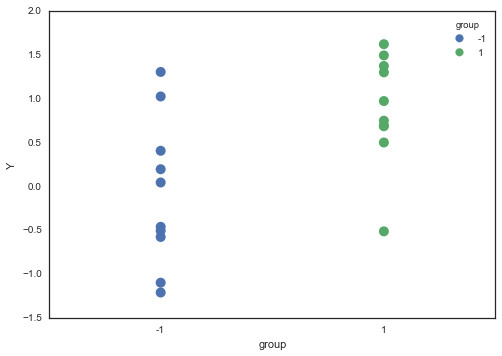

In [34]:
sbn.stripplot(x="group", y="Y", hue="group", data=data,s=10)
pass

Fit regression model

In [16]:
fit_data = smf.ols('Y ~ group', data).fit()

Plot regression

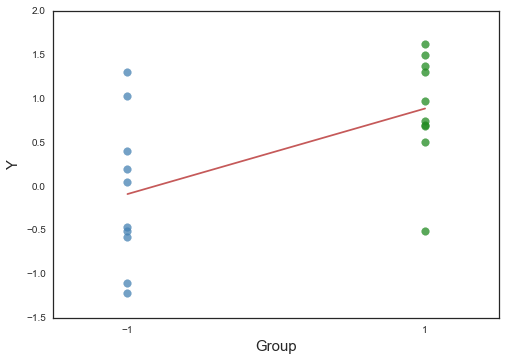

In [17]:
plt.scatter(data.group[data.group == -1], data.Y[data.group == -1], s=60, alpha=0.75, color='steelblue')
plt.scatter(data.group[data.group == 1], data.Y[data.group == 1], s=60, alpha=0.75, color='forestgreen')
groups = [-1,1]
predicted = fit_data.predict(dict(group=groups))
plt.plot(groups, predicted, color='firebrick', alpha=0.75)
plt.xticks([-1,1])
plt.xlabel("Group",fontsize=15)
plt.ylabel("Y", fontsize=15)
pass

Compare regression F-statistic and corresponding p-value to that from ANOVA

In [18]:
fit_data.fvalue, fit_data.f_pvalue

(8.6645825644330685, 0.0086869181036364224)

In [19]:
stats.f_oneway(data.Y[data.group == -1], data.Y[data.group == 1])

F_onewayResult(statistic=8.6645825644330721, pvalue=0.0086869181036364224)

## Multi-group one-way ANOVA as a multiple regression

When we want to consider multiple groups, we have to extend the idea of dummy coding to allow for more groups. We can setup simple dummy variables for $g-1$ groups, or we can use a slight variant called "effect coding".  The results when using effect coding are usually easier to interpret, and that's what we'll use this here.

The two links below contrast dummy and effect coding:

 * Dummy coding: http://www.ats.ucla.edu/stat/mult_pkg/faq/general/dummy.htm
 * Effect coding: http://www.ats.ucla.edu/stat/mult_pkg/faq/general/effect.htm

In [4]:
iris = pd.read_csv("http://roybatty.org/iris.csv")
iris.Species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [5]:
iris.columns = iris.columns.str.replace('.','')
iris.columns

Index(['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species'], dtype='object')

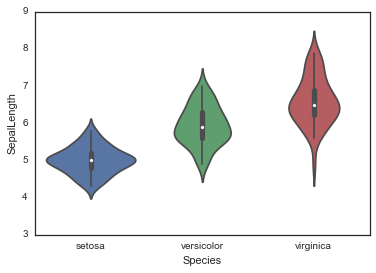

In [8]:
sbn.violinplot(x="Species", y="SepalLength", data=iris)

In [9]:
effect1 = []
effect2 = []
for s in iris.Species:
    if s == 'setosa':
        effect1.append(1)
        effect2.append(0)
    elif s == 'versicolor':
        effect1.append(0)
        effect2.append(1)
    else:
        effect1.append(-1)
        effect2.append(-1)
    

In [10]:
print(effect1)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [12]:
print(effect2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [24]:
# add effect variables to iris data frame
iris.effect1 = effect1
iris.effect2 = effect2

In [25]:
iris_fit = smf.ols("SepalLength ~ effect1 + effect2", iris).fit()

In [26]:
iris_fit.fvalue, iris_fit.f_pvalue

(119.26450218450468, 1.6696691907693826e-31)

In [27]:
stats.f_oneway(iris.SepalLength[iris.Species == "setosa"], 
               iris.SepalLength[iris.Species == "versicolor"],
               iris.SepalLength[iris.Species == "virginica"])

F_onewayResult(statistic=119.26450218450468, pvalue=1.6696691907693826e-31)

If using `statsmodels` you don't need to explicit create the effect coding variables like we did above. You can specify that a variable is a categorical variables in the formula itself.

In [28]:
iris_fit2 = smf.ols('SepalLength ~ C(Species)', iris).fit()

You can then pass the model fit results to `statsmodels.stats.anova.anova_lm` to get an appropriate ANOVA table.

In [29]:
anova.anova_lm(iris_fit2)

,df,sum_sq,mean_sq,F,PR(>F)
C(Species),2,63.212133,31.606067,119.264502,1.669669e-31
Residual,147,38.956200,0.265008,NaN,NaN
